# Most Effective Roles in the 2013 NBA Basketball Season


**Name**: Scott Turro

**NetID**: smturro2

We employ clustering tactics to analyze the NBA players of the 2013 season. By separating the players into groups we found two different types of play styles. These play styles differ in their ability to make blocks, field goals, turnovers and their skill to get rebounds and assists. To further divide the groups we further divided the groups by the amount of playing time and were able to see the All Star players of the 2013 season. Finally we looked at two teams an analyzed what lead to their success and what was their weakness.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score,pairwise_distances
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture
from sklearn.metrics import adjusted_rand_score, silhouette_samples, silhouette_score
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from pyclustertend import hopkins
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import DBSCAN
import time
import sys

# Data

## Retrieval

The Dataset is available at https://www.kaggle.com/razamh/unsupervised-ml. We have extracted nba_2013.csv and put it in the relative directory \data\nba_2013.csv. See repository for more details.

In [2]:
# Get dataset
df_nba_raw = pd.read_csv("data/nba_2013.csv")
df_nba = df_nba_raw.copy()

# Numeric only
df_nba_numeric = df_nba_raw.select_dtypes([np.number])
# Some attributes are highly correlated
df_nba_numeric = df_nba_numeric.drop(columns=["fga","x3pa","x2pa","fta","orb","drb"])
df_nba_numeric = df_nba_numeric.drop(columns=["fg.","x3p.","x2p.","efg.","ft."])
# X = df_nba_numeric


# other
num_features = df_nba_numeric.shape[1]
num_players = df_nba_numeric.shape[0]
uniq_pos = df_nba["pos"].unique()
features_numeric = df_nba_numeric.columns.copy()

# (num samples, num features)
df_nba_numeric.shape

(481, 15)

## Scaling

We scaled each attribute to be distributed as a standard normal distribution. This is because the attributes such as minutes played and age are on severally different scales.

In [3]:
# Divide by minutes played
df_nba_numeric[df_nba_numeric.columns[4:]] = (df_nba_numeric[df_nba_numeric.columns[4:]].T/df_nba_numeric["mp"]).T
df_nba[df_nba_numeric.columns[4:]+"/mp"] = (df_nba_numeric[df_nba_numeric.columns[4:]].T/df_nba_numeric["mp"]).T
df_nba_numeric

# # Rescale each attribute so it is on the scale of 0-1
df_nba_numeric = MinMaxScaler().fit_transform(df_nba_numeric)
df_nba_numeric = pd.DataFrame(df_nba_numeric)
X = df_nba_numeric

# Clusterability

## tSNE Plot

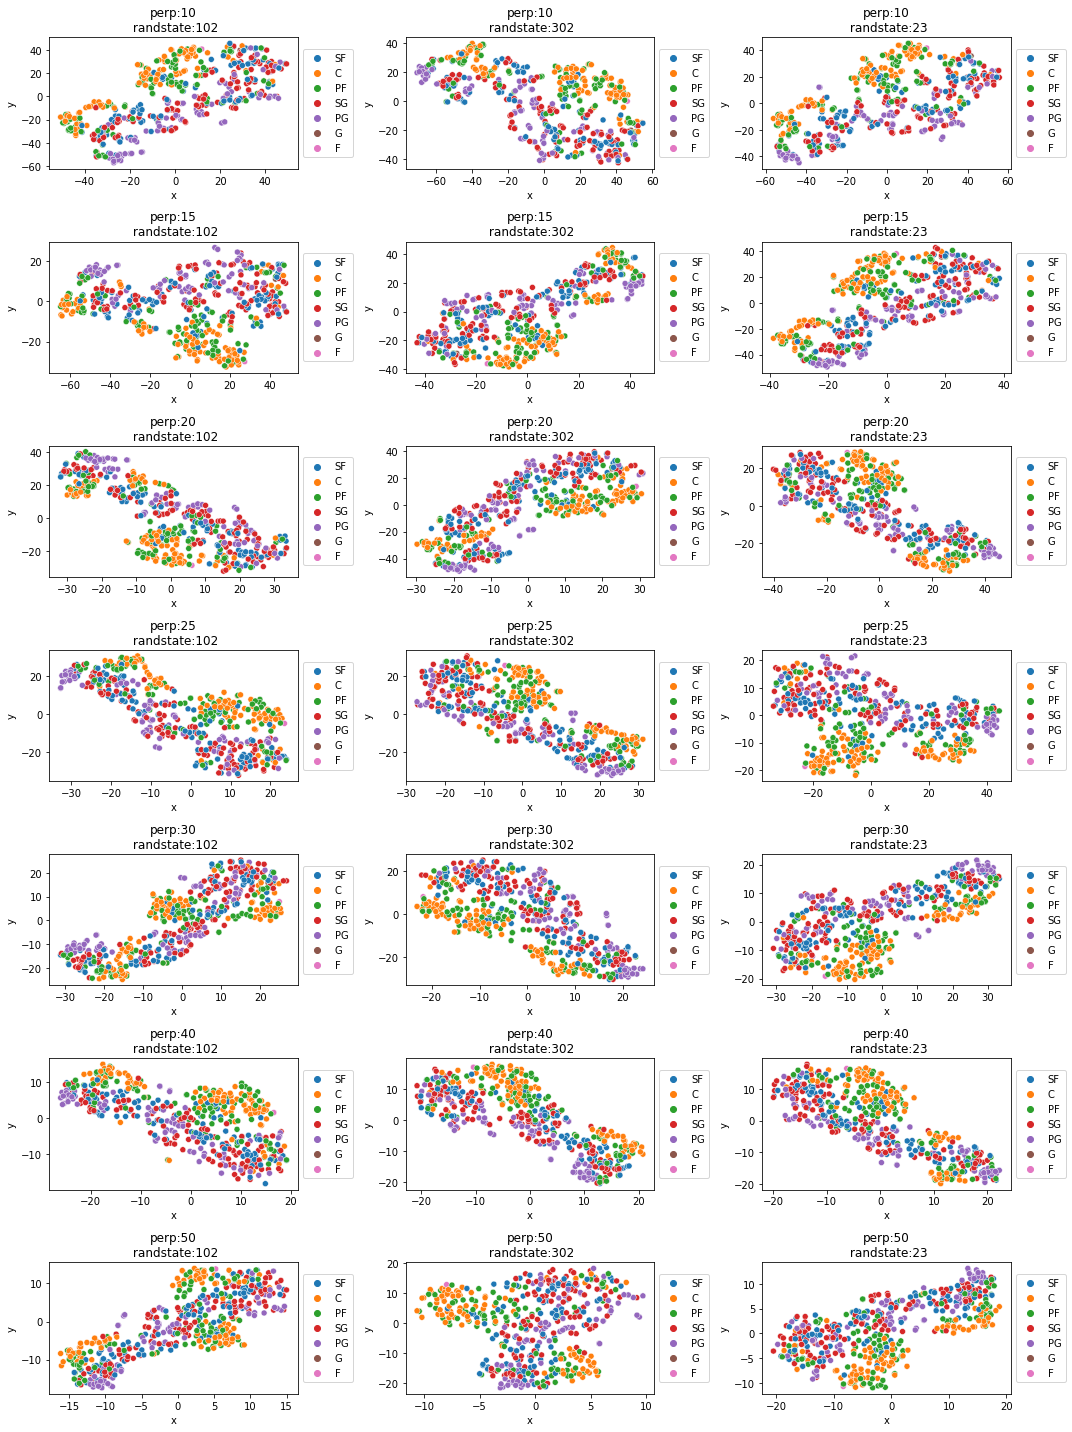

In [4]:
# Plots several tsne plots
# default plots 6 diffrent perplexity values each with 2 diffrent random states
def tsne_plots(df,metric="euclidean",label=None,perplexity_values = [5,10,20,30,40,50],randState_values=[100,200],figsize=(10,5),tight_layout=True):
    fig, ax = plt.subplots(len(perplexity_values),len(randState_values),figsize=figsize)
    for i in range(len(perplexity_values)):
        for j in range(len(randState_values)):
            # Get projected data
            proj = TSNE(2,perplexity=perplexity_values[i],
                        random_state=randState_values[j]).fit_transform(df)
            proj = pd.DataFrame(proj,columns=["x","y"])
            # Plot on ax
            if label is None:
                sns.scatterplot(x="x",
                                y="y",
                                data=proj,
                                ax=ax[i,j])
            else:
                sns.scatterplot(x="x",
                                y="y",
                                data=proj,
                                hue=label,
                                ax=ax[i,j])
                ax[i,j].legend(loc='center left', bbox_to_anchor=(1, 0.5))
            ax[i,j].set_title(f"perp:{perplexity_values[i]}\n randstate:{randState_values[j]}")

    if tight_layout:
        plt.tight_layout()
        
# Plot Several
tsne_plots(df_nba_numeric,
           figsize=(15,20),
           perplexity_values=[10,15,20,25,30,40,50],
           randState_values=[102,302,23],
           label=df_nba_raw["pos"])

In [5]:
# Get Specific Projection
df_nba_tsne = TSNE(2,perplexity=20,random_state=23).fit_transform(df_nba_numeric)
df_nba_tsne = pd.DataFrame(df_nba_tsne,columns=["x","y"])
df_nba_tsne["pos"] = df_nba_raw["pos"]

The tSNE plots shows about 3 clusters which are not well separated. There is not strong evidence that this dataset is clusterable so another measure the Hopkins Statistics was investigated.

## Hopkins Stat

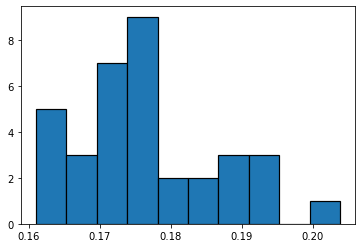

In [6]:
num_trials=35
hopkins_stats=[]
for i in range(0,num_trials):
    n = len(df_nba_numeric)
    p = int(0.1 * n)
    hopkins_stats.append(hopkins(df_nba_numeric,p))
plt.hist(hopkins_stats, edgecolor='black', linewidth=1.2)
pass

These low Hopkins statistics supports the notion that this dataset is clusterable. We may not begin with the analysis.

# Exploring Clusterings

## Mixed Gaussian
Since the clusters are not well separated, we choose to investigate Mixed Gaussian clustering. Here we investigate the AIC and BIC Plots to find a good number of clusters

In [7]:
# Use AIC when Num samples/Num Parameters > 40
print(df_nba_numeric.shape[0]/df_nba_numeric.shape[1])

32.06666666666667


Since we have little samples compared the number of parameters, we should favor looking at the BIC score instead of the AIC.

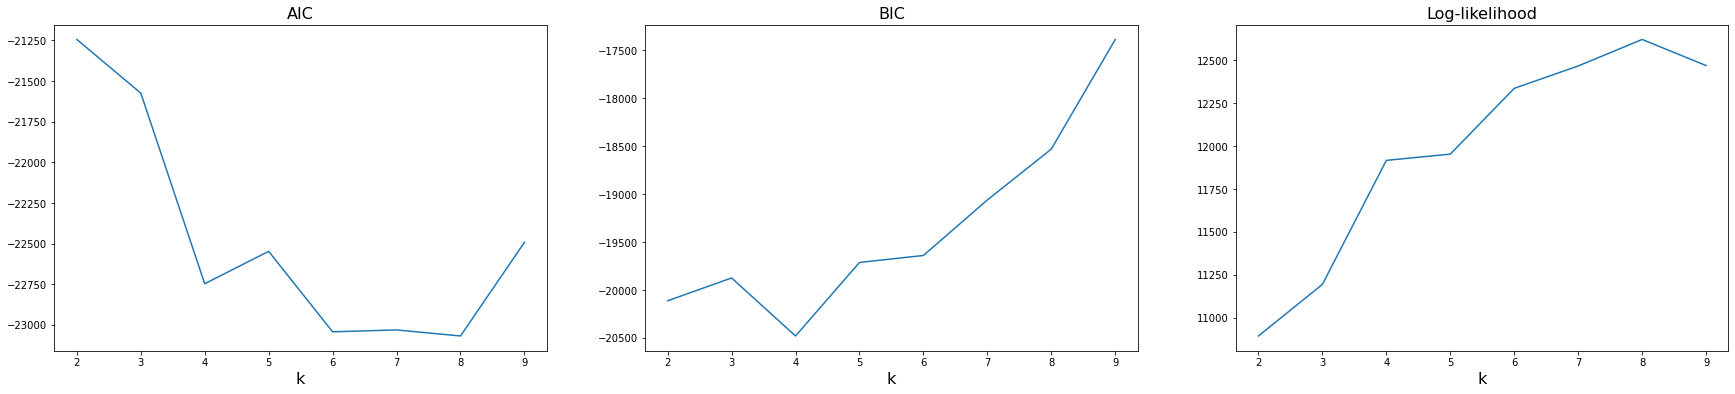

In [8]:
aics = []
bics = []
log_likelihoods = []
k_range =np.arange(2,10)

for k in k_range:
    #Fit the GMM model
    gm = GaussianMixture(n_components=k, random_state=100)
    gm.fit(X)
    
    #Calculate the AIC, BIC, and log-likelihood for this model
    aics.append(gm.aic(X))
    bics.append(gm.bic(X))
    log_likelihoods.append(gm.score(X) * len(X))


#Plot these values
fig, ax = plt.subplots(1, 3, figsize=(30, 6))

#AIC
ax[0].plot(k_range, aics)
ax[0].set_xlabel('k', fontsize=16)
ax[0].set_title('AIC', fontsize=16)

#BIC
ax[1].plot(k_range, bics)
ax[1].set_xlabel('k', fontsize=16)
ax[1].set_title('BIC', fontsize=16)

# Log-likelihood
ax[2].plot(k_range, log_likelihoods)
ax[2].set_xlabel('k', fontsize=16)
ax[2].set_title('Log-likelihood', fontsize=16)

plt.show()

The BIC score suggests 4 clusters should be used, while the AIC suggests 6.

In [9]:
cluster_labels = list()

cluster_labels.append("labels_gauss_4")
model_gauss_4 = GaussianMixture(n_components=3, random_state=100)
df_nba_tsne["labels_gauss_4"]=model_gauss_4.fit_predict(df_nba_numeric)

cluster_labels.append("labels_gauss_7")
model_gauss_7 = GaussianMixture(n_components=6, random_state=100)
df_nba_tsne["labels_gauss_7"]=model_gauss_7.fit_predict(df_nba_numeric)

## Non-negative matrix factorization (NMF)
NMF was investigated since all the player's statistics were non negative. The number of clusters was choosen purely from the tSNE plot.

In [10]:
cluster_labels.append("labels_NMF_3")
model_nmf = NMF(n_components=3, init='random', random_state=100,max_iter=500)
W = model_nmf.fit_transform(df_nba_numeric)
df_nba_tsne["labels_NMF_3"]=W.argmax(axis=1)

## hierarchical Agglomerative Clustering (HAC)
For each of the types of links single, complete, ward, and average the average silhouette scores were plotted against the number of clusters.

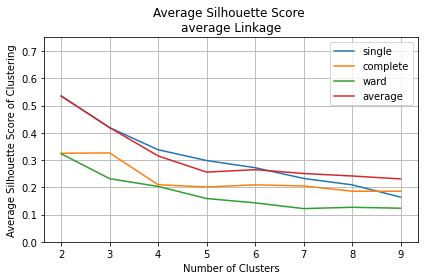

In [31]:
dm = pdist(X, metric='euclidean')
count = 1
for link in ['single', 'complete', 'ward', 'average']:
    avg_ss=[]
    for k in k_range:
        #First, designate the HAC linkage function, and the number of clusters you want to extract from the resulting dendrogram
        hac = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage=link)
        Y_pred = hac.fit_predict(X)
        avg_ss.append(silhouette_score(X, Y_pred))
        
    plt.plot(k_range, avg_ss,label=link)
    count+=1
plt.title('Average Silhouette Score \n%s Linkage'%link)
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score of Clustering')
plt.ylim(0,.75)
plt.grid()
plt.legend()
plt.tight_layout()

n_clusters_single = 4
n_clusters_ward = 6
n_clusters_avg = 6
n_clusters_complete = 4

The number of clusters for each type was determined from the plot. Mostly by which number of clusters produced the best average Silhouette score with some of trial and error. A noticable exception was ward linkage which was choosen to have 6. This decision was made in order to complement the NMF clustering.

In [12]:
cluster_labels.append(f"labels_hac_single_{n_clusters_single}")
model_single = AgglomerativeClustering(n_clusters=n_clusters_ward,
                                     affinity='euclidean',
                                     linkage='single')
df_nba_tsne[f"labels_hac_single_{n_clusters_single}"]= model_single.fit_predict(X)

In [13]:
cluster_labels.append(f"labels_hac_ward_{n_clusters_ward}")
model_ward = AgglomerativeClustering(n_clusters=n_clusters_ward,
                                     affinity='euclidean',
                                     linkage='ward')
df_nba_tsne[f"labels_hac_ward_{n_clusters_ward}"]= model_ward.fit_predict(X)

In [14]:
cluster_labels.append(f"labels_hac_avg_{n_clusters_avg}")
model_avg = AgglomerativeClustering(n_clusters=n_clusters_avg,
                                    affinity='euclidean',
                                    linkage='average')
df_nba_tsne[f"labels_hac_avg_{n_clusters_avg}"]= model_avg.fit_predict(X)

In [15]:
cluster_labels.append(f"labels_hac_complete_{n_clusters_complete}")
model_complete = AgglomerativeClustering(n_clusters=n_clusters_complete,
                                         affinity='euclidean',
                                         linkage='complete')
df_nba_tsne[f"labels_hac_complete_{n_clusters_complete}"]= model_complete.fit_predict(X)

## Plot clusterings

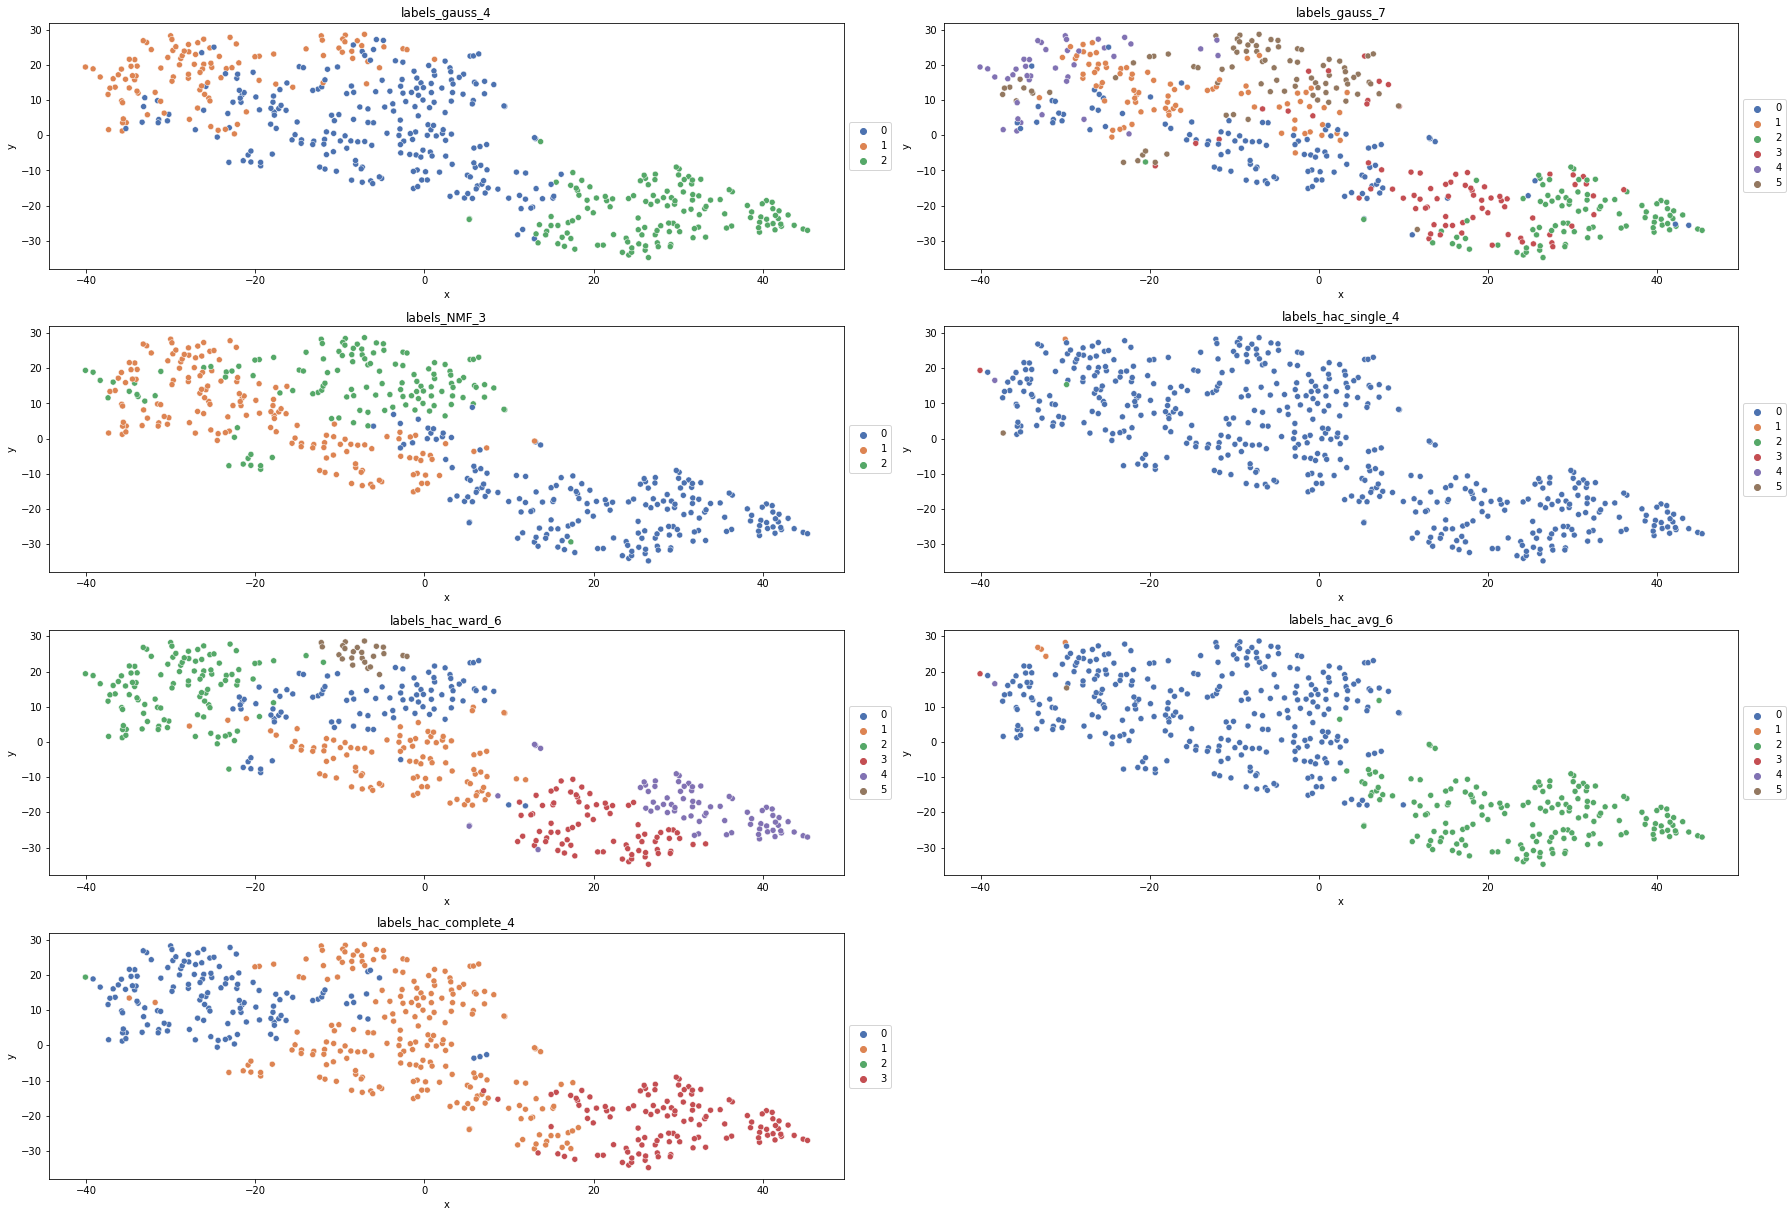

In [16]:
plt.figure(figsize=(25,25))
count = 1
for l in cluster_labels:
    ax = plt.subplot(6,2,count)
    sns.scatterplot(x="x",
                    y="y",
                    data=df_nba_tsne,
                    hue=l,
                    palette="deep",
                    ax=ax)
    ax.set_title(l)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    count+=1
plt.tight_layout()

Many of the HAC algorithms resulted in clusters with one or few players. This is undesirable. Two models were choosen to be investigated further, NMF with 3 clusters and HAC with ward linkage with 6 clusters. A more detailed tSNE plot was created for these clusters below. Gaussian clusterings did not not result in interesting clusters and thus were not choosen to be investigated further.

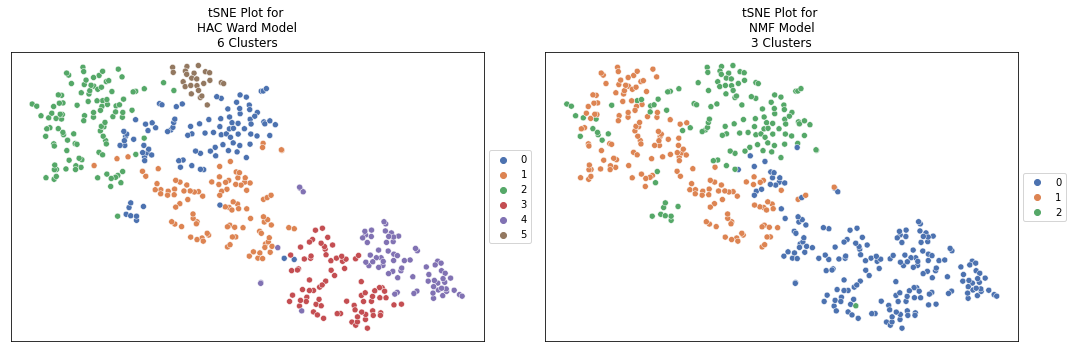

In [34]:
# Add to cluster labels to main dataframe
df_nba["labels_ward"] = df_nba_tsne[f"labels_hac_ward_{n_clusters_ward}"]
df_nba["labels_nmf"] = df_nba_tsne[f"labels_NMF_3"]

# Complete Linkage
plt.figure(figsize=(15,5))
ax = plt.subplot(1,2,1)
sns.scatterplot(x="x",
                y="y",
                data=df_nba_tsne,
                hue=f"labels_hac_ward_{n_clusters_ward}",
                palette="deep",
                ax=ax)
ax.set_title(f"tSNE Plot for \nHAC Ward Model\n{n_clusters_ward} Clusters")
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# NMF
ax = plt.subplot(1,2,2)
sns.scatterplot(x="x",
                y="y",
                data=df_nba_tsne,
                hue="labels_NMF_3",
                palette="deep",
                ax=ax)
ax.set_title(f"tSNE Plot for \nNMF Model\n{3} Clusters")
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

Our two main clusterings complement each other very well since it seems the HAC clustering splits each of the NMF clusters into two. 

# Model: NMF

## Centroids

In [18]:
# Set up model
num_clusters = 3
model = model_nmf
clustering_label = f"labels_nmf"


centroids = pd.pivot_table(df_nba,index = clustering_label)
centroids.to_csv("centroids_nmf.csv")
# Pick out Interesting Columns
centroids[["g","gs","mp","ast/mp","tov/mp","trb/mp","blk/mp","x2p.","x3p."]]

,g,gs,mp,ast/mp,tov/mp,trb/mp,blk/mp,x2p.,x3p.
labels_nmf,,,,,,,,,
0,73.094737,56.236842,2151.042105,0.000046,0.000028,0.000085,0.000009,0.489785,0.305862
1,37.200000,4.043750,610.737500,0.000969,0.000714,0.001573,0.000018,0.420040,0.314697
2,44.083969,7.389313,677.610687,0.000098,0.000209,0.011313,0.000160,0.490040,0.178506


### The All Stars
Cluster 0. These players play almost every game and have the most minutes played out of all of the clusters. They have the best shooting percentage in 2 pointers and 3 pointers.
### Play Makers
Cluster 1. These players have lots of turn overs and assists per minute. They are decent shooters and 
### Bruiser in the Paint
Cluster 2. These players have great blocks and rebounds per minute. They have very low 3 point percentage but the best 2 point percentage.

## Distribution of positions

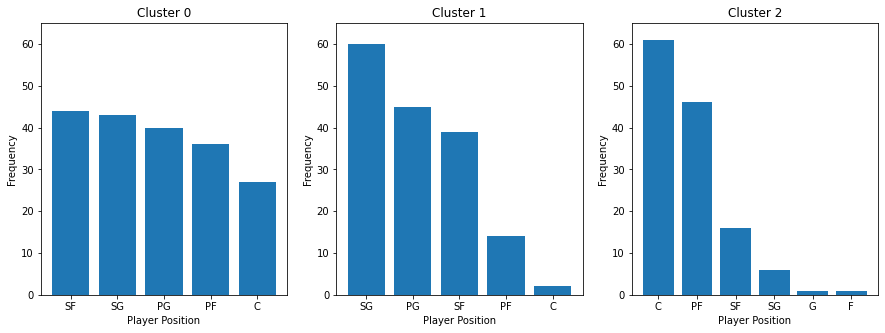

In [19]:
plt.figure(figsize=(15,5))
for i in range(num_clusters):
    ax = plt.subplot(1,3,i+1)
    df_temp = df_nba[df_nba[clustering_label] == i]
    df_temp = df_temp["pos"].value_counts()
    plt.bar(df_temp.index,df_temp.values)
    plt.xlabel("Player Position")
    plt.ylabel("Frequency")
    plt.title(f"Cluster {i}")
    plt.ylim((0,65))

For the all stars, there is a variety of player positions however positions such as small forward and shooting guard are more favored. For play makers, this cluster is dominated by shooting guards then point guards and some small forwards. The last cluster, the bruisers, are almost all centers and power forwards.

## Silhouette Plots

For n_clusters = 3 The average silhouette_score is : 0.2152137973473388


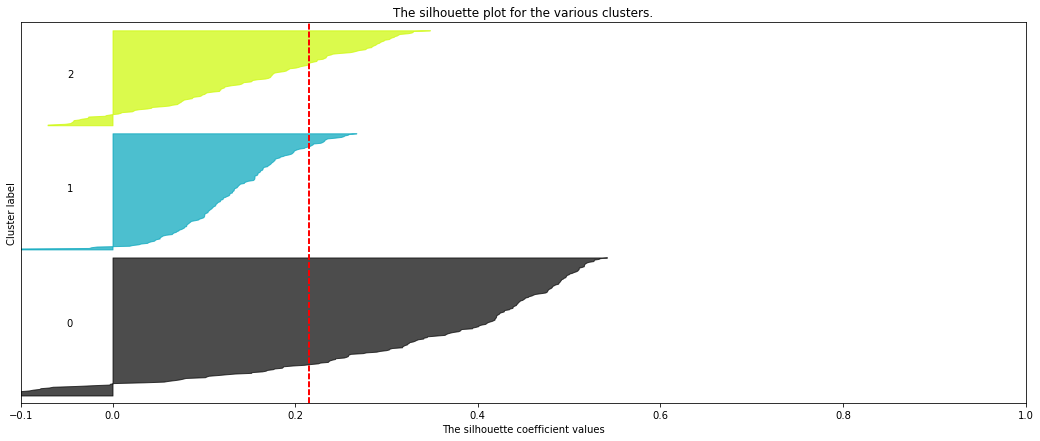

In [20]:
# Taken from lecture 3 notes
def show_silhouette_plots(X,cluster_labels):
    
    #How many clusters in your clustering?
    n_clusters=len(np.unique(cluster_labels))    

    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient fcan range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])


    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
    

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()
    
    return

show_silhouette_plots(df_nba_numeric, df_nba[clustering_label])

Clusters 1 and 2 have the least amount of cohesion and separation on average. While Cluster 0 has the best. Clusters 2 and 0 seem to have similar shapes with a gradual decrease in silhouettes while cluster 1 has a more sharper decrease. All these clusters have objects with negative silhouette scores.

# Model: HAC with Ward Linkage

## Centroids

In [21]:
# Set up model
num_clusters = n_clusters_ward
model = model_ward
clustering_label = f"labels_ward"

centroids = pd.pivot_table(df_nba,index = clustering_label)
centroids.to_csv("centroids_ward.csv")
# Pick out Interesting Columns
centroids[["g","gs","mp","ast/mp","pts/mp","trb/mp","blk/mp","x2p.","x3p."]]

,g,gs,mp,ast/mp,pts/mp,trb/mp,blk/mp,x2p.,x3p.
labels_ward,,,,,,,,,
0,56.333333,9.585859,904.868687,0.000077,0.000457,0.000297,0.000037,0.487832,0.213061
1,66.939394,11.707071,1402.303030,0.000088,0.000332,0.000104,0.000009,0.461138,0.353647
2,16.467290,1.196262,181.205607,0.001399,0.022981,0.015424,0.000082,0.413761,0.267327
3,71.846154,61.051282,2050.448718,0.000030,0.000199,0.000118,0.000014,0.502926,0.227186
4,72.932432,70.770270,2443.878378,0.000062,0.000201,0.000058,0.000004,0.482673,0.358753
5,27.000000,2.708333,275.083333,0.000155,0.001700,0.001927,0.000445,0.469820,0.133871


### The Average Players
These are clusters 0 and 1 which both have an average amount of play time. Clusters 0 seems to be a more bruiser type build while Cluster 1 seems to have a more play making style.

### The Bench
These are clusters 2 and 5. They have played very little games and minutes so their stats per minute are not reliable to compare. Looking at shot percentage is better indication. Cluster 5 can shoot 2 pointers very well but can not shoot 3 pointers. Cluster 2 has a more uniform short percent on average between 2 pointers and 3 pointers.

### The All Stars
Clusters 3 and 4. These two clusters together make up a large porportion of cluster 1 from the NMF clustering. Cluster 4 has the best 3 point percentage on average and has good stats such as assists per minute. Cluster 3 is the All Star bruiser cluster with great blocks and rebounds

### Clustering Separation and Cohesion

For n_clusters = 6 The average silhouette_score is : 0.142861832997871


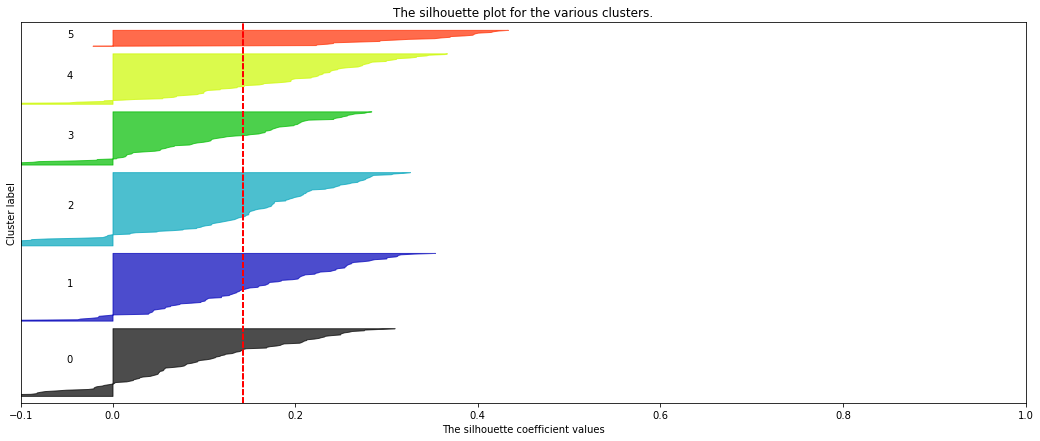

In [33]:
show_silhouette_plots(df_nba_numeric, df_nba[clustering_label])

These silhouette plots look poor, so the results should be taken lightly. The scores die off pretty fast and each cluster has points with negative scores. Cluster 5, play makers on the bench, has the least amount of players in the cluster. This cluster also appears to have the best separation and cohesion on average.

## Who Are the All Star Shooters?

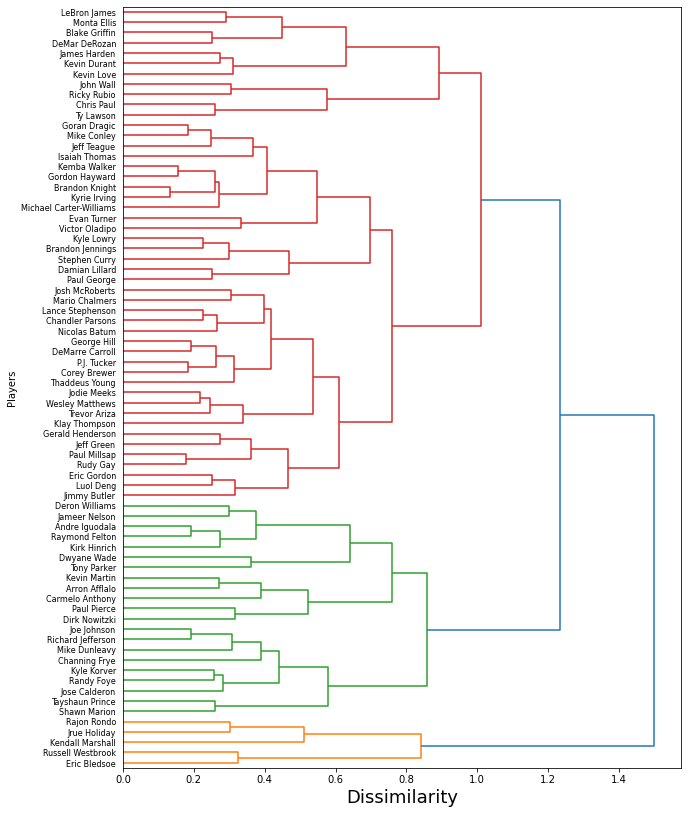

In [24]:
# Dendrogram
df_temp = df_nba_numeric[df_nba[clustering_label] == 4]
dm = pdist(df_temp, metric='euclidean')
Z = linkage(dm, method='complete')
fig, ax = plt.subplots(figsize=(10, 14))
d = dendrogram(Z, orientation='right', labels=df_nba[df_nba[clustering_label] == 4]['player'].array, ax=ax)
ax.set_xlabel('Dissimilarity', fontsize=18)
ax.set_ylabel('Players', fontsize=10)
plt.yticks(fontsize=8)
plt.show()

It is no surprise to see players such as Steph Curry and LeBron James in this cluster. One can notice a separation a players for example, Jrue Holiday is not well known for his 3 point shots, while Steph Curry is consider one of the greatest 3 point shooters of all time.

## Who Road the Bench in 2013?

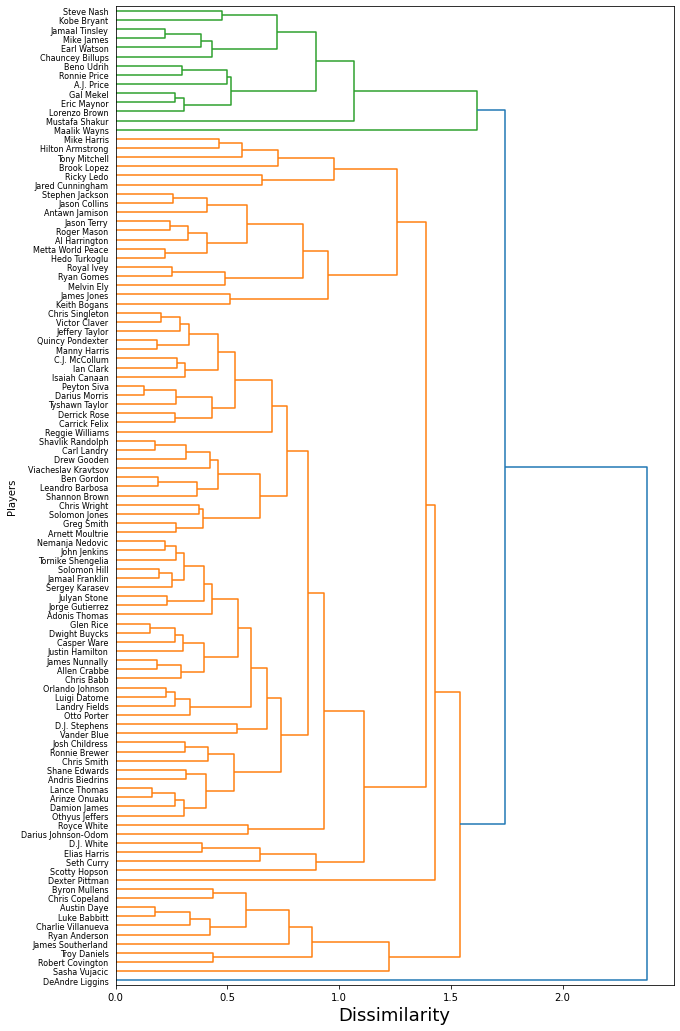

In [25]:
# Dendrogram
df_temp = df_nba_numeric[df_nba[clustering_label] == 2]
dm = pdist(df_temp, metric='euclidean')
Z = linkage(dm, method='complete')
fig, ax = plt.subplots(figsize=(10, 18))
d = dendrogram(Z, orientation='right', labels=df_nba[df_nba[clustering_label] == 2]['player'].array, ax=ax)
ax.set_xlabel('Dissimilarity', fontsize=18)
ax.set_ylabel('Players', fontsize=10)
plt.yticks(fontsize=8)
plt.show()

We can see that Kobe Bryant and Derrick Rose were classified as people who road the bench in the 2013 season. Even though these players are considered the some of the best players to ever play Basketball. Both of these players suffered an injury in the 2013 season causing them to be unable to play.

# Analysis of Teams

## 2013 Miami Heat
The heat won the NBA Finals in 2013, so its important to see what made their team so good. They had 80% win/loss record this season and were defending champions from 2012.

### The All Stars

In [26]:
team = "MIA"
df_temp = df_nba[df_nba["bref_team_id"] == team]
df_temp = df_temp[df_temp["labels_nmf"] == 0]
df_temp[["player","pts","trb","blk","x2p.","x3p.","labels_ward"]]

,player,pts,trb,blk,x2p.,x3p.,labels_ward
36,Shane Battier,298,138,39,0.492308,0.347619,3
59,Chris Bosh,1281,522,78,0.568707,0.339450,3
87,Mario Chalmers,716,214,16,0.500000,0.384956,4
95,Norris Cole,527,160,5,0.450920,0.344828,1
225,LeBron James,2089,533,26,0.621777,0.379085,4
448,Dwyane Wade,1028,241,29,0.556927,0.281250,4


These are all strong players that helped Miami win the championship. LeBron James has an outstanding shooting percentage and stands out by having an extreme amount of points. Chris Bosh who has the second amount of points has a great amount of rebounds and blocks. Norris Cole was classified as an average player by the ward clustering however he was classified as an All Star by NMF.

### Team Make up

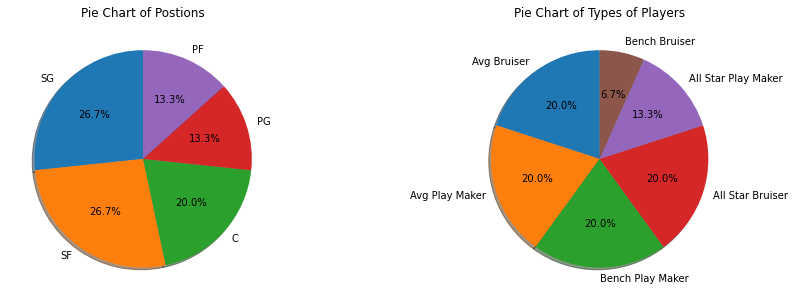

In [27]:
plt.figure(figsize=(15,5))

# Pi chart of postions
plt.subplot(1,2,1)
df_temp = df_nba[df_nba["bref_team_id"] == team]
df_temp = df_temp["pos"].value_counts()
plt.pie(df_temp.values,
        labels=df_temp.index, 
        autopct='%1.1f%%',
        shadow=True, 
        startangle=90)
plt.title("Pie Chart of Postions")

# Pie chart of Clusting
plt.subplot(1,2,2)
df_temp = df_nba[df_nba["bref_team_id"] == team]
df_temp = df_temp["labels_ward"].value_counts()
labels = ["Avg Bruiser","Avg Play Maker","Bench Play Maker","All Star Bruiser","All Star Play Maker","Bench Bruiser"]
plt.pie(df_temp.values,
        labels=labels, 
        autopct='%1.1f%%',
        shadow=True, 
        startangle=90)
plt.title("Pie Chart of Types of Players")
fig.set_facecolor('white')
plt.show()

The 2013 Miami had a good variety of positions on their roster. They also had a good portion of All Star Players. Having this much All-Start players was certainly a key factor in winning the championship

## 2013 Chicago Bulls
The chicago bulls were looked at as they are our home town team. They made it to the second round in the play offs where they lost to the miami heat 4 to 1 in the series. Their record for the 2013 season was 55%. Good enough to make t he play offs but not a strong competitor.

### The All Stars

In [28]:
team = "CHI"
df_temp = df_nba[df_nba["bref_team_id"] == team]
df_temp = df_temp[df_temp["labels_nmf"] == 0]
df_temp[["player","pts","trb","blk","x2p.","x3p.","labels_ward"]]

,player,pts,trb,blk,x2p.,x3p.,labels_ward
58,Carlos Boozer,1042,632,22,0.457055,0.000000,3
74,Jimmy Butler,878,330,36,0.456954,0.283333,4
132,Mike Dunleavy,929,345,46,0.466667,0.379630,4
207,Kirk Hinrich,666,192,26,0.419098,0.351240,4
330,Joakim Noah,1007,900,121,0.476190,0.000000,3
403,Tony Snell,346,124,15,0.455696,0.320225,1


There are some notable people on this list. Carlos Boozer and Joakim Noah who never shoot 3's, instead dominated the paint by getting rebounds. Mike Dunleavy was our strongest shooter with a 37% shot percentage from 3. 

### Team Make up

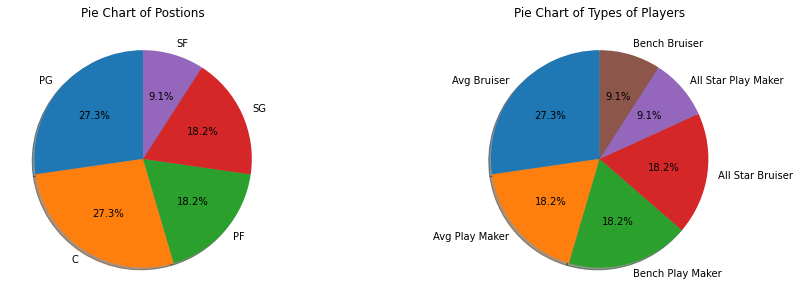

In [29]:
plt.figure(figsize=(15,5))

# Pi chart of postions
plt.subplot(1,2,1)
df_temp = df_nba[df_nba["bref_team_id"] == team]
df_temp = df_temp["pos"].value_counts()
plt.pie(df_temp.values,
        labels=df_temp.index, 
        autopct='%1.1f%%',
        shadow=True, 
        startangle=90)
plt.title("Pie Chart of Postions")

# Pie chart of Clusting
plt.subplot(1,2,2)
df_temp = df_nba[df_nba["bref_team_id"] == team]
df_temp = df_temp["labels_ward"].value_counts()
labels = ["Avg Bruiser","Avg Play Maker","Bench Play Maker","All Star Bruiser","All Star Play Maker","Bench Bruiser"]
plt.pie(df_temp.values,
        labels=labels, 
        autopct='%1.1f%%',
        shadow=True, 
        startangle=90)
plt.title("Pie Chart of Types of Players")
fig.set_facecolor('white')
plt.show()

Compared the 2013 Miami Heat, the 2013 Chicago team has much less All star play Makers. However we did have a good amount of All Star bruisers. Our weakest area could of been improved if Derrick Rose was not injured this year. Our distribution of players roughly resembles Miami's, which is trivial.

## Results and Further More
In our initial clustering we found 3 different types of players. All star players, Bruisers and Play Makers. Bruisers were defined by players who can make 2 point baskets, get rebounds and make blocks. Play Makers could shoot 3 point field goals, make turn overs and had a lot of assists. 

By clustering with HAC using ward linkage we were able to roughly split each of these clusters in two. The All star plays were split by type, All Star Bruiser or All Star Play Maker. And the other initial clusters were split by the amount of time they played, an average or low amount. We saw injured players were classified as people on the Bench since the amount of time they played was low. We also saw this clustering did not have as well of a separation and cohesion then the NMF Clustering. Therefore these results should be taken lightly.

If given more time it we would look at how the players and groups evolved in time by looking at future data. Clustering by average stats over many seasons would also provide more accurate statistics as well as add the ability to analyze injured players.